In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.gridspec as gridspec

import corner
import pickle

import binary_c
import xrb
import xrb.src.constants as c
from xrb.binary import binary_evolve
from xrb.src import stats
from xrb.SF_history import sf_history
from xrb.pop_synth import pop_synth


from xrb.src.core import *
set_data_path("../data")


%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [ ]:
c.sf_scheme = "SMC"

start = time.time()

chains = stats.run_emcee_population(nburn=10000, nsteps=200000, nwalkers=80, binary_scheme='binary_c', 
                                    threads=2, return_sampler=False, print_progress=True)

end = time.time()

print "Elapsed time:", int((end-start)/3600), "hours and", (end-start)%3600.0, "seconds" 

190000 steps remaining, 10000 steps currently running
180000 steps remaining, 10000 steps currently running
170000 steps remaining, 10000 steps currently running
160000 steps remaining, 10000 steps currently running
150000 steps remaining, 10000 steps currently running
140000 steps remaining, 10000 steps currently running
130000 steps remaining, 10000 steps currently running
120000 steps remaining, 10000 steps currently running
110000 steps remaining, 10000 steps currently running
100000 steps remaining, 10000 steps currently running
90000 steps remaining, 10000 steps currently running
80000 steps remaining, 10000 steps currently running
70000 steps remaining, 10000 steps currently running
60000 steps remaining, 10000 steps currently running
50000 steps remaining, 10000 steps currently running
40000 steps remaining, 10000 steps currently running
30000 steps remaining, 10000 steps currently running
20000

In [ ]:
np.save("../data/SMC_chains.npy", chains)

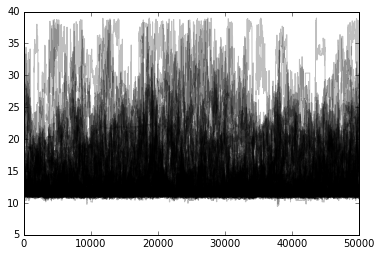

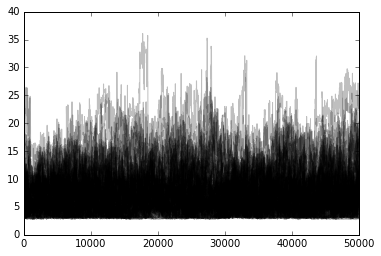

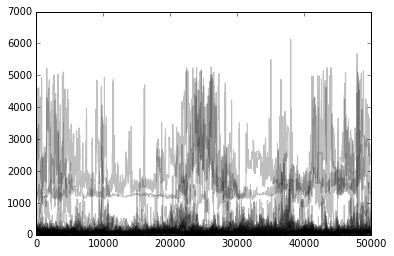

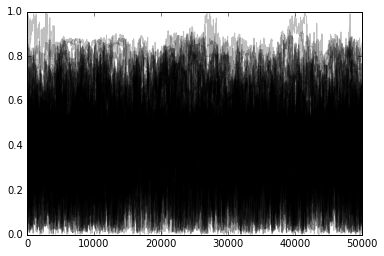

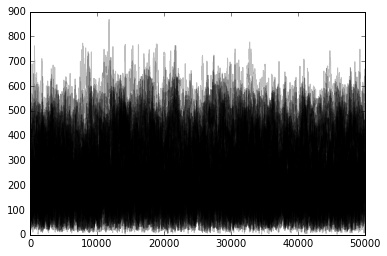

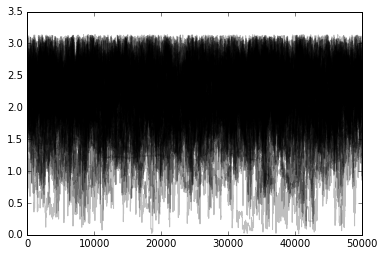

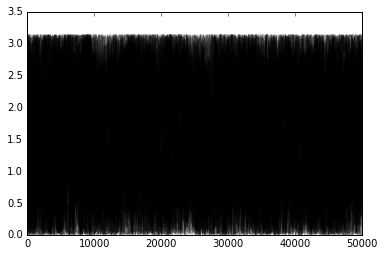

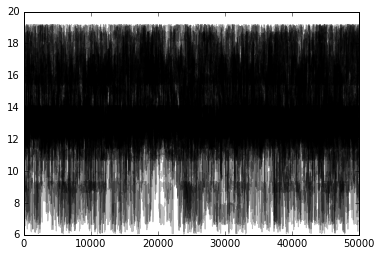

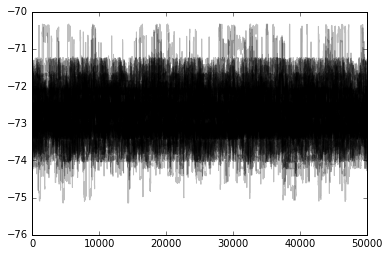

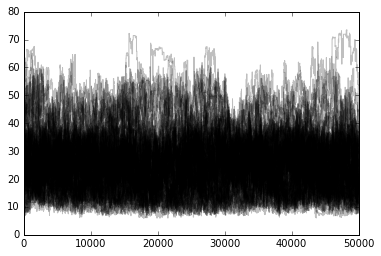

In [6]:
for i in range(sampler.dim):
    plt.figure()
    for chain in sampler.chain[...,i]:
        if i < 3:
            plt.plot(10**chain, alpha=0.25, color='k', drawstyle='steps')
        else:
            plt.plot(chain, alpha=0.25, color='k', drawstyle='steps')
        
plt.show()

In [16]:
pickle.dump(sampler, open("../data/SMC_sampler.obj", "wb"))

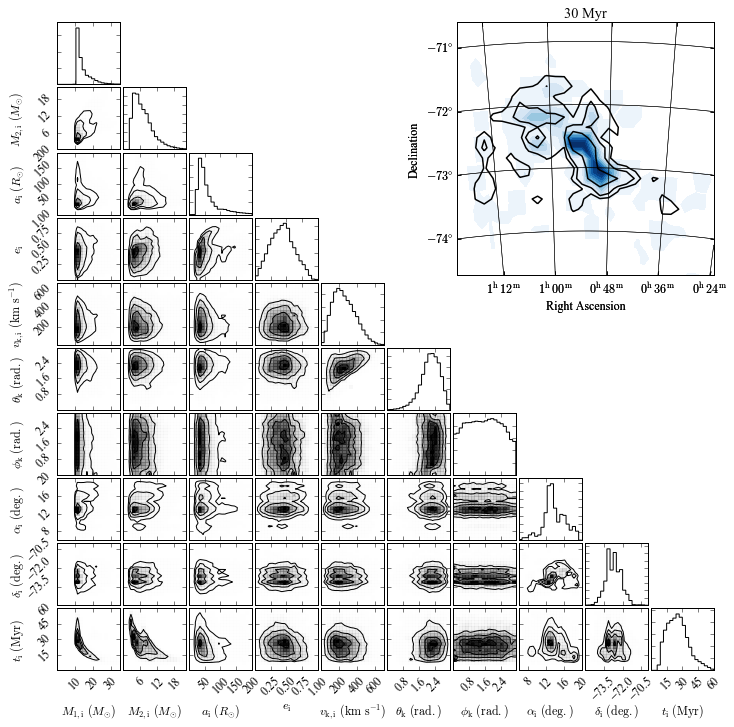

In [15]:
# Corner plot
fontProperties = {'family':'serif', 'serif':['Times New Roman'], 'weight':'normal', 'size':12}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal', \
                                         weight='normal', stretch='normal', size=12)
plt.rc('font', **fontProperties)

fig, ax = plt.subplots(10,10, figsize=(10,10))


chain = sampler.flatchain
sampler_data = np.array([10**chain.T[0], 10**chain.T[1], 10**chain.T[2], chain.T[3], \
                         chain.T[4], chain.T[5], chain.T[6], chain.T[7], chain.T[8], chain.T[9]]).T


labels = [r"$M_{\rm 1, i}\ (M_{\odot})$", r"$M_{\rm 2, i}\ (M_{\odot})$", r"$a_{\rm i}\ (R_{\odot})$", \
          r"$e_{\rm i}$", r"$v_{\rm k, i}\ ({\rm km}\ {\rm s}^{-1})$", r"$\theta_{\rm k}\ ({\rm rad.})$", \
          r"$\phi_{\rm k}\ ({\rm rad.})$", r"$\alpha_{\rm i}\ ({\rm deg.})$", \
          r"$\delta_{\rm i}\ ({\rm deg.}) $", r"$t_{\rm i}\ ({\rm Myr})$"]
plt_range = ([0,35], [0,22], [0,200], [0,1], [0,700], [0,np.pi], [0,np.pi], [6,20], [-75,-70], [0,60])

hist2d_kwargs = {"plot_datapoints" : False}
fig = corner.corner(sampler_data, fig=fig, labels=labels, range=plt_range, max_n_ticks=4, **hist2d_kwargs)
# fig = corner.corner(sampler.flatchain, fig=fig, labels=labels, max_n_ticks=4, **hist2d_kwargs)

ra_out = sampler.flatchain.T[7]
dec_out = sampler.flatchain.T[8]
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[3,2],
                       height_ratios=[2,3]
                       )
smc_plot, ax1 = sf_history.get_plot_polar(30, fig_in=fig, gs=gs[1], ra_dist=ra_out, dec_dist=dec_out, \
                                          dist_bins=30, xwidth=2.0, ywidth=2.0, xgrid_density=6)


ax1.set_position([0.55, 0.55, 0.3, 0.3])


# Shift axis labels
for i in np.arange(10):
    ax[i,0].yaxis.set_label_coords(-0.5, 0.5)
    ax[9,i].xaxis.set_label_coords(0.5, -0.5)


plt.subplots_adjust(bottom=0.07, left=0.07, top=0.97)


plt.savefig('../figures/population_smc.pdf', rasterized=True)
# plt.show()

### Now, run the autocorrelation length test

In [2]:
sampler = pickle.load(open("../data/SMC_sampler.obj","rb"))

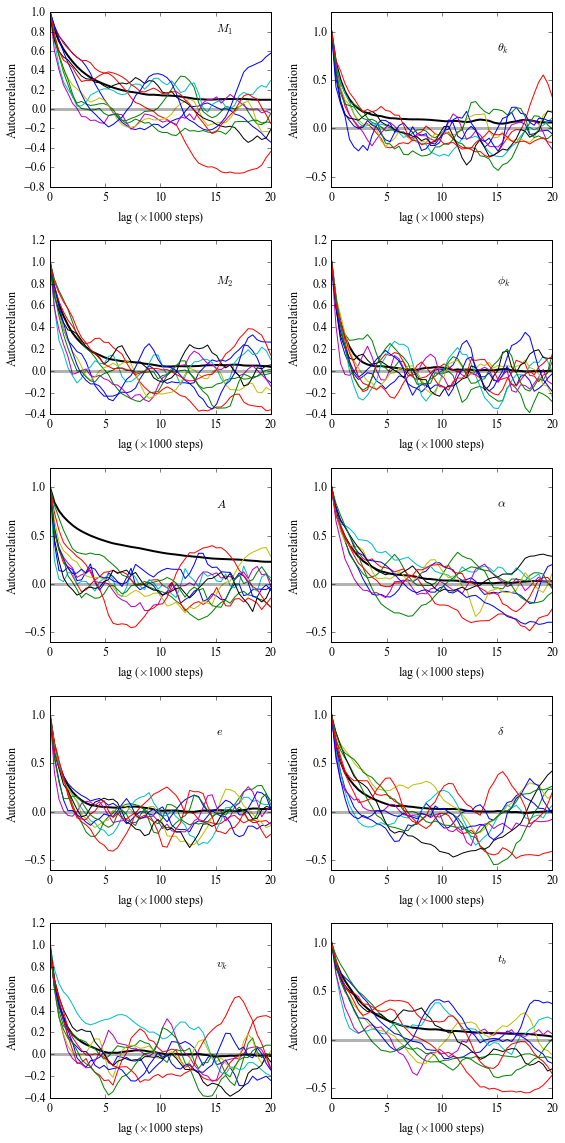

In [18]:
from pandas import Series

fig, ax = plt.subplots(5, 2, figsize=(8,16))

var = [r'$M_1$',r'$M_2$',r'$A$',r'$e$',r'$v_k$',r'$\theta_k$',r'$\phi_k$',r'$\alpha$',r'$\delta$',r'$t_b$']

N = 50

xmin, xmax = 0, 20000
factor = 1000.0

for k in np.arange(10):
    
    
    kx = k%5
    ky = k/5
    
    # Plot the autocorrelation of the flatchain
    autocorr = np.zeros(N)
    series = Series(data=sampler.flatchain.T[k])
    for i in np.arange(N):
        autocorr[i] = Series.autocorr(series, lag=int(i*float(xmax-xmin)/N))

    ax[kx,ky].plot(np.linspace(xmin,xmax,N)/factor, autocorr, color='k', linewidth=2)

        
    # Plot the autocorrelation of 10 sample chains
    for j in np.arange(10):
        autocorr = np.zeros(N)
        series = Series(data=sampler.chain[j,:,k])

        for i in np.arange(N):
            autocorr[i] = Series.autocorr(series, lag=int(i*float(xmax-xmin)/N))

        ax[kx,ky].plot(np.linspace(xmin,xmax,N)/factor, autocorr)

    
    ax[kx,ky].axhline(0.0, color='k', alpha=0.3, linewidth=3)
    ax[kx,ky].set_xlabel(r'lag ($\times$1000 steps)')
    ax[kx,ky].set_ylabel(r'Autocorrelation')
    ax[kx,ky].text(15, 0.8, var[k])
    
    
plt.tight_layout()

plt.savefig("../figures/smc_autocorrelation.pdf")
# plt.show()

### Now, let's determine the derived parameters

In [19]:
metallicity = 0.008


M1_today = np.zeros(len(sampler.flatchain))
M2_today = np.zeros(len(sampler.flatchain))
A_today = np.zeros(len(sampler.flatchain))
ecc_today = np.zeros(len(sampler.flatchain))
v_sys_today = np.zeros(len(sampler.flatchain))
time_SN_1 = np.zeros(len(sampler.flatchain))
P_orb_today = np.zeros(len(sampler.flatchain))
ra_today = np.zeros(len(sampler.flatchain))
dec_today = np.zeros(len(sampler.flatchain))



for i, sample in zip(np.arange(len(sampler.flatchain)), sampler.flatchain):
    log_M1, log_M2, log_A, ecc, v_k, theta, phi, alpha, delta, t_b = sample
    
    M1 = 10**log_M1
    M2 = 10**log_M2
    A = 10**log_A
    
    
    orbital_period = binary_evolve.A_to_P(M1, M2, A)


    output = binary_c.run_binary(M1, M2, orbital_period, ecc, metallicity, t_b, \
                                 v_k, theta, phi, v_k, theta, phi, 0, 1)


    # Direct from binary_c outputs
    M1_today[i] = output[0]
    M2_today[i] = output[1]
    A_today[i] = output[2]
    ecc_today[i] = output[3]
    v_sys_today[i] = output[4]
    time_SN_1[i] = output[6]
    
    # Orbital period
    P_orb_today[i] = binary_evolve.A_to_P(M1_today[i], M2_today[i], A_today[i])
    
    
    ############## To get the position today ############
    # Get a random theta and phi for polar, position angle
    ran_phi = pop_synth.get_phi(1)
    ran_theta = pop_synth.get_theta(1)
    
    # Projected separation between birth and current positions
    ang_sep = (t_b - time_SN_1[i]) * v_sys_today[i] * c.yr_to_sec * 1.0e6 / c.dist_LMC * np.sin(ran_theta)

    # Get the new ra and dec
    ra_today[i], dec_today[i] = pop_synth.get_new_ra_dec(alpha, delta, ang_sep, ran_phi)


In [20]:
data_derived = [M1_today, M2_today, A_today, ecc_today, v_sys_today, time_SN_1, ra_today, dec_today]

In [21]:
pickle.dump(data_derived, open("../data/SMC_sampler_derived.obj", "wb"))

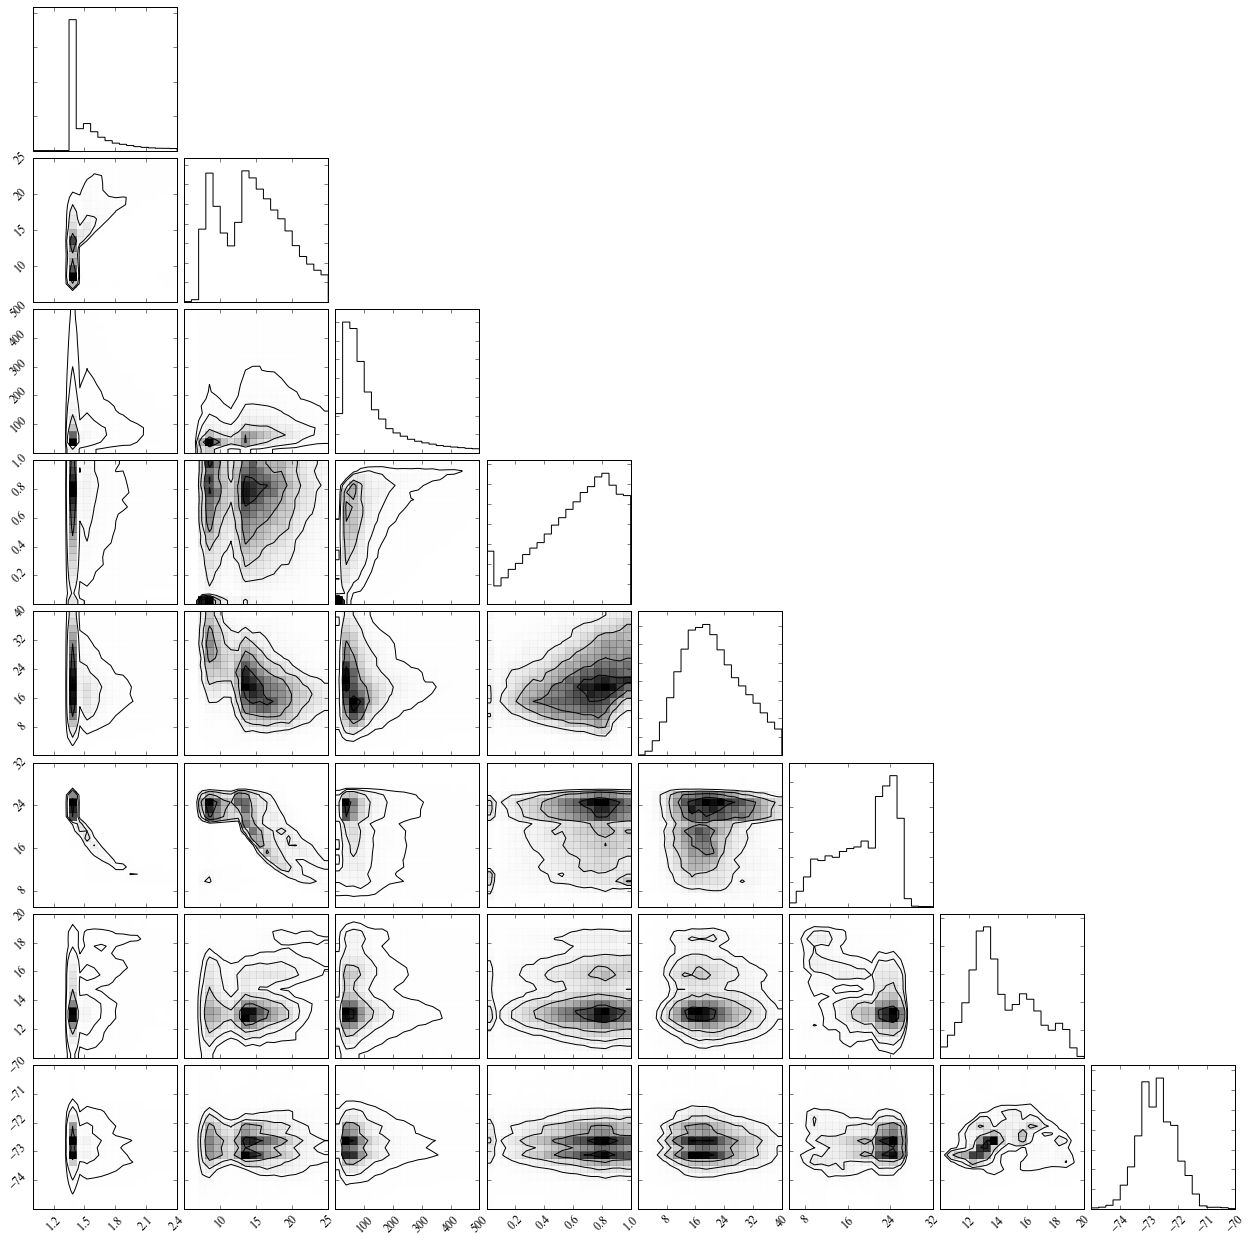

In [27]:
range = [[1,2.4], [5,25], [0,500], [0,1], [0,40], [5,32], [10, 20], [-75, -70]]

hist2d_kwargs = {"plot_datapoints" : False}
corner.corner(np.array(data_derived).T, range=range, **hist2d_kwargs)

plt.savefig("../figures/SMC_derived.pdf")
# plt.show()

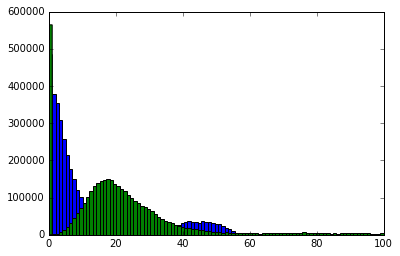

In [33]:
bins = np.linspace(0, 100, 100)
plt.hist(sampler.flatchain.T[9] - time_SN_1, bins=bins)

plt.hist(v_sys_today, bins=bins)

plt.show()

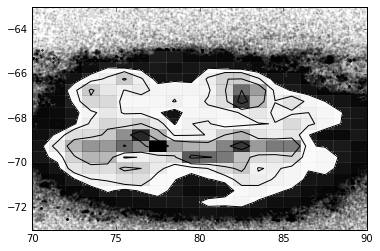

In [45]:
corner.hist2d(ra_today, dec_today, range=[[70, 90], [-73, -63]])

In [37]:
angle = (t_b - time_SN_1[i]) * v_sys_today[i] * c.yr_to_sec * 1.0e6 / c.dist_LMC * np.sin(ran_theta)

print ra_today[i], dec_today[i]
print pop_synth.get_new_ra_dec(ra_today[i], dec_today[i], angle, 1.0)

82.8851806307 -70.0506802156
(array([ 82.98783281]), array([-70.02819171]))


In [50]:
print len(np.where(M2_today < 2.0)[0])
print len(ecc_today)
print output

559493
4000000
(1.3586157692301786, 18.4277555044553, 253.8664837802298, 0.9150255556607425, 18.113105747391334, 20.476332594228705, 25.108296567392248, 0.0, 27.4782, 13, 1, 0, '')


In [25]:
print sampler.chain.shape

chain = 0
step = 0
param = 0
print sampler.chain[chain, 0::100, param].shape

sampler_small_1 = sampler.chain[:, 0::100, :]
sampler_small_2 = sampler.chain[:, 50::100, :]

print sampler_small_1.shape, sampler_small_2.shape

(80, 50000, 10)
(500,)
(80, 500, 10) (80, 500, 10)


In [42]:
tmp_array = np.empty((80,0,10))

print tmp_array

[]


In [43]:
print tmp_array.shape
tmp_array = np.concatenate((tmp_array, sampler_small_1), axis=1)
print tmp_array.shape
tmp_array = np.concatenate((tmp_array, sampler_small_2), axis=1)
print tmp_array.shape


(80, 0, 10)
(80, 500, 10)
(80, 1000, 10)


In [32]:
pickle.dump(sampler_combined, open("../data/SMC_sampler_small.obj", "wb"))

In [33]:
test = pickle.load(open("../data/SMC_sampler_small.obj", "rb"))

print test.shape

(80, 1000, 10)
